In [39]:
""" Suppress Pandas future warnings """
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


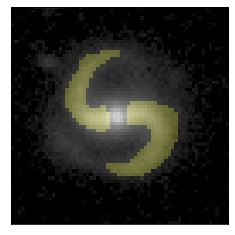

In [1]:
""" Overlay a single mask on respective image """
from PIL import Image
import matplotlib.pyplot as plt

IMG_FILE = r"..\data\Tadaki_Segmentation\set_1\orig_images\42261258421956171.jpg"
MSK_FILE = r"..\data\Tadaki_Segmentation\set_1\segmentation\42261258421956171.tif"

img = Image.open(IMG_FILE)
msk = Image.open(MSK_FILE)

plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='gnuplot', alpha=0.2)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

1/1 [==============================] - 0s 21ms/step


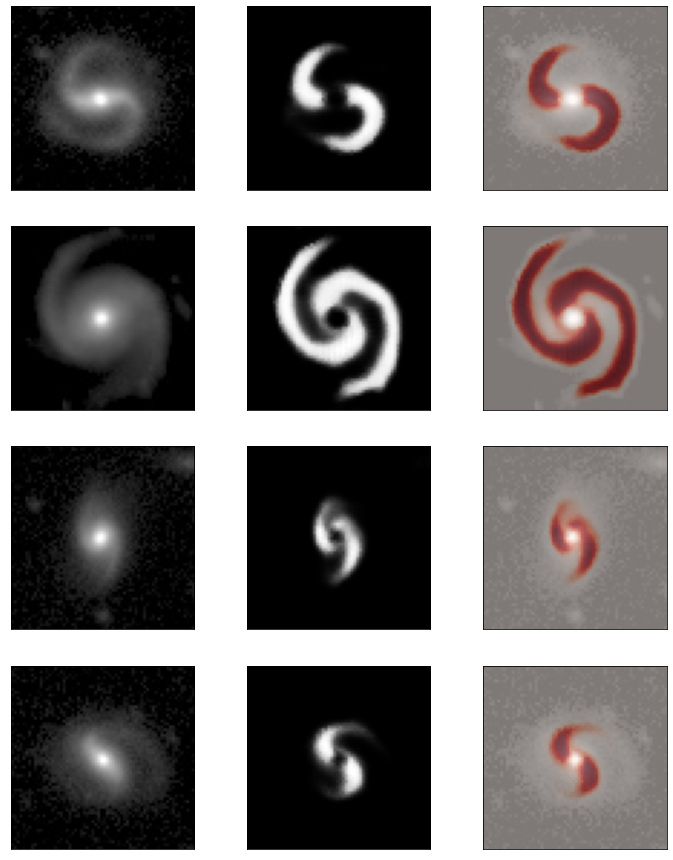

In [2]:
""" Print predictions from model """

import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

MODEL_PATH = os.path.join(os.pardir, "models", "tuned_model.keras")
image_filepaths = [
    r"..\data\Tadaki_Segmentation\set_2\images\42261258421956171.jpg",
    r"..\data\Tadaki_Segmentation\set_2\images\40576682054147100.jpg",
    r"..\data\Tadaki_Segmentation\set_2\images\40576682054152186.jpg",
    r"..\data\Tadaki_Segmentation\set_2\images\42204354400250369.jpg",
    ]

model = tf.keras.models.load_model(MODEL_PATH)

imgs = [np.expand_dims(np.array(Image.open(fp)), axis=0) for fp in image_filepaths]

preds = [model.predict(tf.convert_to_tensor(img, dtype=tf.float64)) for img in imgs]

plt.figure(figsize=(12,60))

for n, img in enumerate(imgs):
    img = img.reshape((64,64))
    pred = preds[n].reshape((64,64))

    plt.subplot(15,3,3*n+1)
    plt.imshow(img, cmap='gray')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(15,3,3*n+2)
    plt.imshow(pred, cmap='gray')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(15,3,3*n+3)
    plt.imshow(img, cmap='gray')
    plt.imshow(pred, cmap='Reds', alpha=0.5)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    

plt.show()


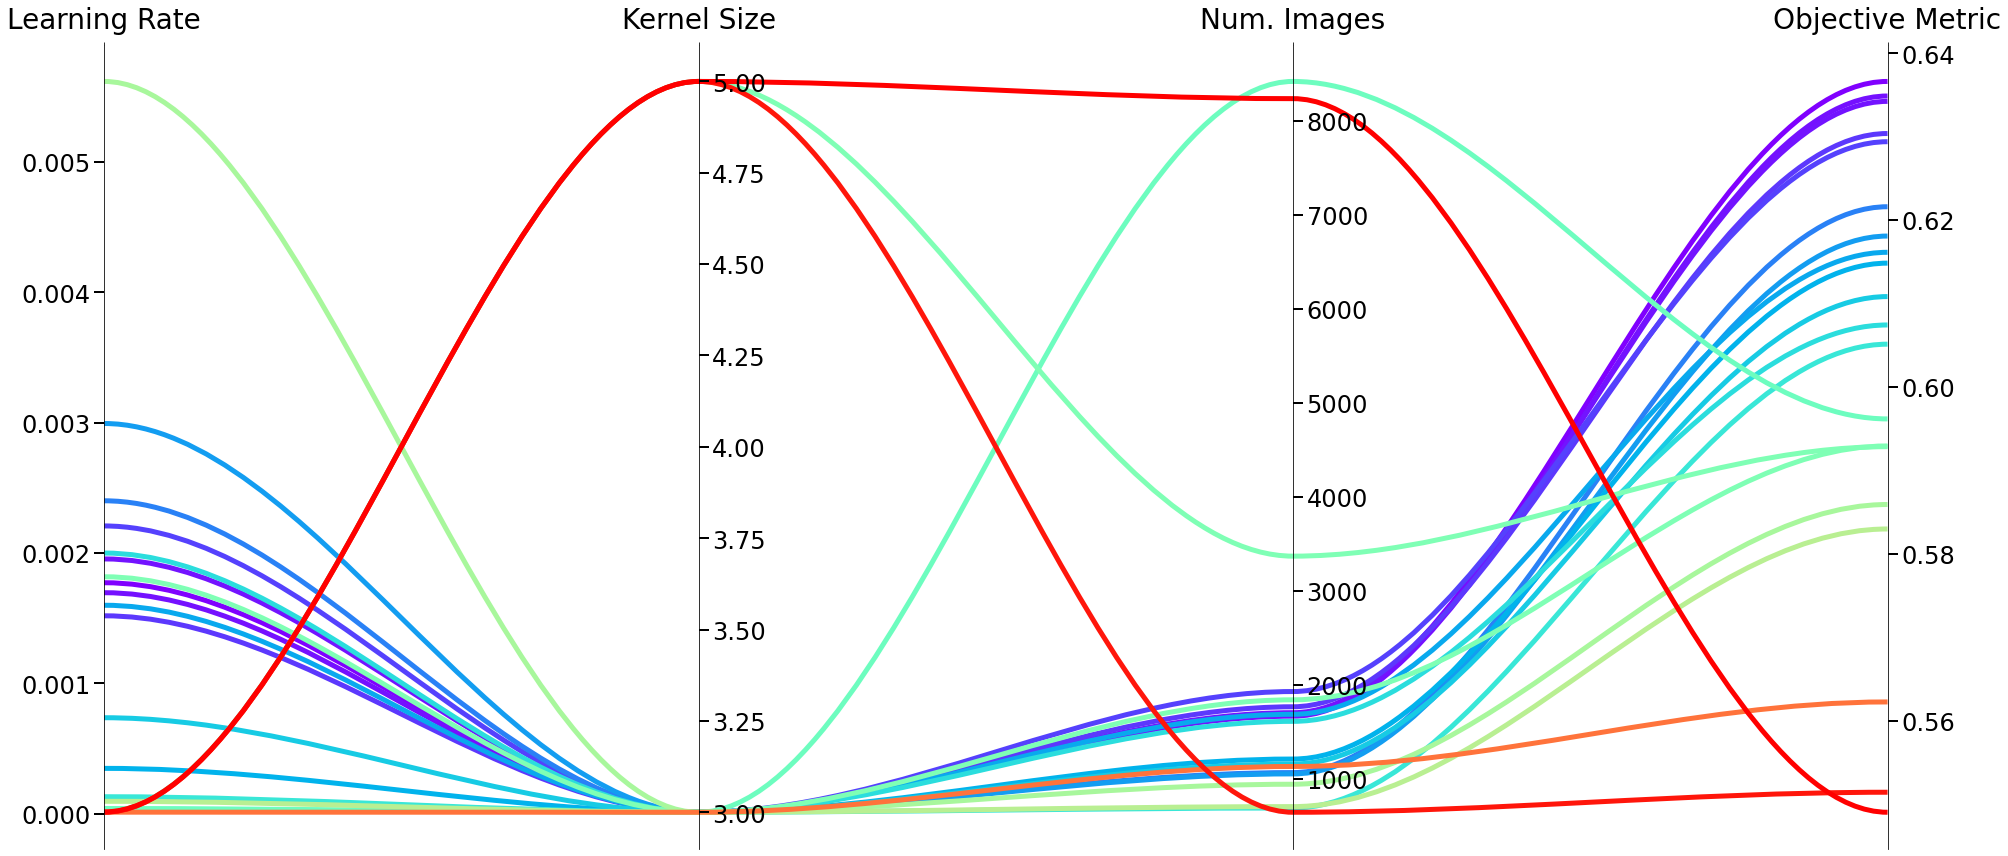

[1.77197778e-03 3.00000000e+00 1.69300000e+03 6.36623167e-01]


In [9]:
# Credit: Inspired by https://stackoverflow.com/a/60401570/10341389
""" Plot Parallel Coordinates plot of Hyperparameter Combinations """
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import json


"""
Expects following JSON shape
    {
        "Objective": OBJECTIVE_TITLE
        "Results": [
            {
                "Trial": TRIAL_ID,
                "Hyperparameters": {
                    "learning_rate": float,
                    "kernel_size": int,
                    "num_images": int,
                    "Score": float
                }
            }
        ]
    }
"""
HP_RESULTS_FILE = r"..\models\hp_tuning_results.json"

with open(HP_RESULTS_FILE, "r") as read_file:
    data = json.load(read_file)

fig, host = plt.subplots(figsize=(28,12))

# create some dummy data
ynames = ['Learning Rate', 'Kernel Size', 'Num. Images', "Objective Metric"]
y1 = [d['Hyperparameters']['learning_rate'] for d in data['Results']]
y2 = [d['Hyperparameters']['kernel_size'] for d in data['Results']]
y3 = [d['Hyperparameters']['num_images'] for d in data['Results']]
y4 = [-d['Hyperparameters']['Score'] for d in data['Results']]

# organize the data
ys = np.dstack([y1, y2, y3, y4])[0]
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='y', labelsize=24, length=10, width=2)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=28)
host.tick_params(axis='x', which='major', pad=7)

host.spines['right'].set_visible(False)
host.xaxis.tick_top()
#host.set_title('Hyperparameter Tuning: Parallel Coordinates Plot', fontsize=18,y=1.1)

cmap = plt.cm.get_cmap('rainbow_r')
norm = mpl.colors.Normalize(vmin=min(y4), vmax=max(y4))

for j in range(ys.shape[0]):
    
    # to just draw straight lines between the axes:
    # host.plot(range(ys.shape[1]), zs[j,:], c=colors[(category[j] - 1) % len(colors) ])

    # create bezier curves
    # for each axis, there will a control vertex at the point itself, one at 1/3rd towards the previous and one
    #   at one third towards the next axis; the first and last axis have one less control vertex
    # x-coordinate of the control vertices: at each integer (for the axes) and two inbetween
    # y-coordinate: repeat every point three times, except the first and last only twice
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    
    # for x,y in verts: host.plot(x, y, 'go') # to show the control points of the beziers
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=5, edgecolor=cmap(norm(y4[j])))
    host.add_patch(patch)
plt.tight_layout()
plt.show()
print(ys[0])

1/1 [==============================] - 0s 18ms/step


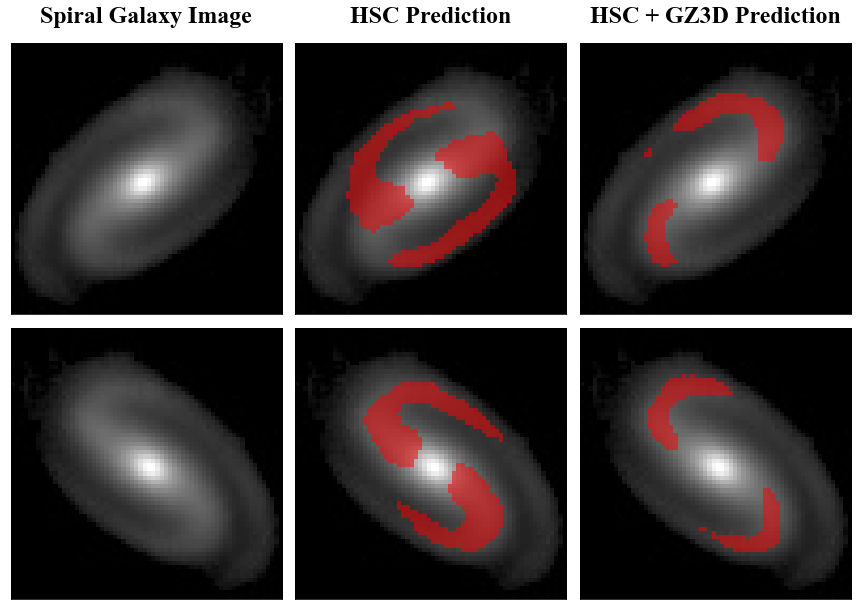

In [116]:
""" Print predictions from model """

import os
import tensorflow as tf
from PIL import Image, ImageOps
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

MODEL2_PATH = os.path.join(os.pardir, "models", "tuned_model.keras")
MODEL3_PATH = os.path.join(os.pardir, "models", "tuned_model_set_3.keras")

galaxy_ids = [
    #"41113630275568911", # Confused by multiple arms
    #"41113651750400882", # Loose spirals
    #"41121876612765981",
    
    #"41131518814350475", # Tight Spirals
    #"42063621206860327",
    
    #'45840847375198015', # Ambiguous
    #'42697219077337997'  
    
    #"40967944984871531", # Z spirals
    "40981272268399741"
]

folder = "..\data\Tadaki+20_spiral\Tadaki+20_Z"

def compare(galaxy_ids, folder):

    image_filepaths = [os.path.join(folder, f"{f}.jpg") for f in galaxy_ids]

    model_set2 = tf.keras.models.load_model(MODEL2_PATH)
    model_set3 = tf.keras.models.load_model(MODEL3_PATH)

    imgs = [np.expand_dims(np.array(Image.open(fp)), axis=0) for fp in image_filepaths]
    
    # mirror images
    #imgs = imgs + [np.expand_dims(np.array(ImageOps.mirror(Image.open(fp))), axis=0) for fp in image_filepaths]

    preds_set2 = [model_set2.predict(tf.convert_to_tensor(img, dtype=tf.float64)) for img in imgs]
    preds_set3 = [model_set3.predict(tf.convert_to_tensor(img, dtype=tf.float64)) for img in imgs]

    overlay_cmap = mpl.colors.ListedColormap(['none', 'red'])

    plt.figure(figsize=(12,60))

    for n, img in enumerate(imgs):
        img = img.reshape((64,64))
        pred_2 = preds_set2[n].reshape((64,64))
        pred_3 = preds_set3[n].reshape((64,64))
        
        plt.subplot(15,3,3*n+1)
        if (n == 0):
            plt.title("Spiral Galaxy Image", fontsize=24, fontname='Times New Roman', y=1.05, weight='bold')
        plt.imshow(img, cmap='gray')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        plt.subplot(15,3,3*n+2)
        if (n == 0):
            plt.title("HSC Prediction", fontsize=24, fontname='Times New Roman', y=1.05, weight='bold')
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_2>0.5, cmap=overlay_cmap, alpha=0.5)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        plt.subplot(15,3,3*n+3)
        if (n == 0):
            plt.title("HSC + GZ3D Prediction", fontsize=24, fontname='Times New Roman', y=1.05, weight='bold')
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_3>0.5, cmap=overlay_cmap, alpha=0.5)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()

compare(galaxy_ids, folder)

In [114]:
""" Compute IoU, Dice and BCE for each model on each dataset"""

from os import listdir
from os.path import isfile, join
import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image, ImageOps

mirror = True

img_folder_path = r"..\data\Tadaki_Segmentation\set_2\images"
msk_folder_path = r"..\data\Tadaki_Segmentation\set_2\masks_png"

image_filepaths = [f for f in listdir(img_folder_path) if isfile(join(img_folder_path, f))]
mask_filepaths = [f for f in listdir(msk_folder_path) if isfile(join(msk_folder_path, f))]

imgs  = [np.expand_dims(np.array(Image.open(join(img_folder_path, path))), axis=0) for path in image_filepaths]
masks = [np.expand_dims(np.array(Image.open(join(msk_folder_path, path))), axis=0) for path in mask_filepaths]

if(mirror):
    imgs  = [np.expand_dims(np.array(ImageOps.mirror(Image.open(join(img_folder_path, path)))), axis=0) for path in image_filepaths]
    masks = [np.expand_dims(np.array(ImageOps.mirror(Image.open(join(msk_folder_path, path)))), axis=0) for path in mask_filepaths]

model_set2 = tf.keras.models.load_model(MODEL2_PATH)
model_set3 = tf.keras.models.load_model(MODEL3_PATH)

preds_set2 = [model_set2.predict(tf.convert_to_tensor(img, dtype=tf.float64), verbose=0) for img in imgs]
preds_set3 = [model_set3.predict(tf.convert_to_tensor(img, dtype=tf.float64), verbose=0) for img in imgs]

def iou(im1, im2):

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    union = np.logical_or(im1, im2)

    return intersection.sum() / float(union.sum())

def dice(im1, im2, empty_score=1.0):

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

def bce(y_true, y_pred):
    
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    
    return -np.mean(term_0+term_1)

result_df = pd.DataFrame(columns=["Model", "IoU", "Dice", "BCE"])

for n, msk in enumerate(masks):
    msk = msk.reshape((64,64))
    pred_2 = preds_set2[n].reshape((64,64)) > 0.5
    pred_3 = preds_set3[n].reshape((64,64)) > 0.5
    
    result_df = result_df.append({
        "Model": "Set 2",
        "IoU": iou(msk, pred_2),
        "Dice": dice(msk, pred_2),
        "BCE": bce(msk, pred_2)
        }, ignore_index=True)
    
    result_df = result_df.append({
        "Model": "Set 3",
        "IoU": iou(msk, pred_3),
        "Dice": dice(msk, pred_3),
        "BCE": bce(msk, pred_3)
        }, ignore_index=True)
    
hsc_avg_df = pd.DataFrame(columns=["Model", "IoU", "Dice", "BCE"])
hsc_avg_df = hsc_avg_df.append({
    "Model": "Set 2",
    "IoU": result_df.loc[result_df["Model"]=="Set 2"]["IoU"].mean(),
    "Dice": result_df.loc[result_df["Model"]=="Set 2"]["Dice"].mean(),
    "BCE": result_df.loc[result_df["Model"]=="Set 2"]["BCE"].mean()
    }, ignore_index=True)

hsc_avg_df = hsc_avg_df.append({
    "Model": "Set 3",
    "IoU": result_df.loc[result_df["Model"]=="Set 3"]["IoU"].mean(),
    "Dice": result_df.loc[result_df["Model"]=="Set 3"]["Dice"].mean(),
    "BCE": result_df.loc[result_df["Model"]=="Set 3"]["BCE"].mean()
    }, ignore_index=True)

print("Tested on SSP HSC Data Only")
hsc_avg_df

Tested on SSP HSC Data Only


,Model,IoU,Dice,BCE
0,Set 2,0.349508,0.509840,0.78778
1,Set 3,0.343645,0.495876,0.72843


In [48]:
""" Compute IoU, Dice and BCE for each model on each dataset"""

from os import listdir
from os.path import isfile, join
import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image, ImageOps

img_folder_path = r"..\data\galaxyzoo3d\rescaled_img"
msk_folder_path = r"..\data\galaxyzoo3d\bin_msk"

image_filepaths = [f for f in listdir(img_folder_path) if isfile(join(img_folder_path, f))]
mask_filepaths = [f for f in listdir(msk_folder_path) if isfile(join(msk_folder_path, f))]

imgs  = [np.expand_dims(np.array(Image.open(join(img_folder_path, path))), axis=0) for path in image_filepaths]
masks = [np.expand_dims(np.array(Image.open(join(msk_folder_path, path))), axis=0) for path in mask_filepaths]

if(mirror):
    imgs  = [np.expand_dims(np.array(ImageOps.mirror(Image.open(join(img_folder_path, path)))), axis=0) for path in image_filepaths]
    masks = [np.expand_dims(np.array(ImageOps.mirror(Image.open(join(msk_folder_path, path)))), axis=0) for path in mask_filepaths]

model_set2 = tf.keras.models.load_model(MODEL2_PATH)
model_set3 = tf.keras.models.load_model(MODEL3_PATH)

preds_set2 = [model_set2.predict(tf.convert_to_tensor(img, dtype=tf.float64), verbose=0) for img in imgs]
preds_set3 = [model_set3.predict(tf.convert_to_tensor(img, dtype=tf.float64), verbose=0) for img in imgs]

def iou(im1, im2):

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    union = np.logical_or(im1, im2)

    return intersection.sum() / float(union.sum())

def dice(im1, im2, empty_score=1.0):

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

def bce(y_true, y_pred):
    
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    
    return -np.mean(term_0+term_1)

result_df = pd.DataFrame(columns=["Model", "IoU", "Dice", "BCE"])

for n, msk in enumerate(masks):
    msk = msk.reshape((64,64))
    pred_2 = preds_set2[n].reshape((64,64)) > 0.5
    pred_3 = preds_set3[n].reshape((64,64)) > 0.5
    
    result_df = result_df.append({
        "Model": "Set 2",
        "IoU": iou(msk, pred_2),
        "Dice": dice(msk, pred_2),
        "BCE": bce(msk, pred_2)
        }, ignore_index=True)
    
    result_df = result_df.append({
        "Model": "Set 3",
        "IoU": iou(msk, pred_3),
        "Dice": dice(msk, pred_3),
        "BCE": bce(msk, pred_3)
        }, ignore_index=True)
    
gz_avg_df = pd.DataFrame(columns=["Model", "IoU", "Dice", "BCE"])
gz_avg_df = gz_avg_df.append({
    "Model": "Set 2",
    "IoU": result_df.loc[result_df["Model"]=="Set 2"]["IoU"].mean(),
    "Dice": result_df.loc[result_df["Model"]=="Set 2"]["Dice"].mean(),
    "BCE": result_df.loc[result_df["Model"]=="Set 2"]["BCE"].mean()
    }, ignore_index=True)

gz_avg_df = gz_avg_df.append({
    "Model": "Set 3",
    "IoU": result_df.loc[result_df["Model"]=="Set 3"]["IoU"].mean(),
    "Dice": result_df.loc[result_df["Model"]=="Set 3"]["Dice"].mean(),
    "BCE": result_df.loc[result_df["Model"]=="Set 3"]["BCE"].mean()
    }, ignore_index=True)

print("Tested on GalaxyZoo3D Data Only")
gz_avg_df

Tested on GalaxyZoo3D Data Only


,Model,IoU,Dice,BCE
0,Set 2,0.281147,0.418472,0.841522
1,Set 3,0.432944,0.587753,0.593043


In [57]:
""" Find weighted average of IoU, Dice and BCE to find overall performance """

hsc_weight = 0.5
gz_weight = 0.5

avg_df = pd.DataFrame(columns=["Model", "IoU", "Dice", "BCE"])
avg_df = avg_df.append({
    "Model": "Set 2",
    "IoU": gz_avg_df.loc[gz_avg_df["Model"]=="Set 2"]["IoU"].values[0]*gz_weight + hsc_avg_df.loc[hsc_avg_df["Model"]=="Set 2"]["IoU"].values[0]*hsc_weight,
    "Dice": gz_avg_df.loc[gz_avg_df["Model"]=="Set 2"]["Dice"].values[0]*gz_weight + hsc_avg_df.loc[hsc_avg_df["Model"]=="Set 2"]["Dice"].values[0]*hsc_weight,
    "BCE": gz_avg_df.loc[gz_avg_df["Model"]=="Set 2"]["BCE"].values[0]*gz_weight + hsc_avg_df.loc[hsc_avg_df["Model"]=="Set 2"]["BCE"].values[0]*hsc_weight
    }, ignore_index=True)

avg_df = avg_df.append({
    "Model": "Set 3",
    "IoU": gz_avg_df.loc[gz_avg_df["Model"]=="Set 3"]["IoU"].values[0]*gz_weight + hsc_avg_df.loc[hsc_avg_df["Model"]=="Set 3"]["IoU"].values[0]*hsc_weight,
    "Dice": gz_avg_df.loc[gz_avg_df["Model"]=="Set 3"]["Dice"].values[0]*gz_weight + hsc_avg_df.loc[hsc_avg_df["Model"]=="Set 3"]["Dice"].values[0]*hsc_weight,
    "BCE": gz_avg_df.loc[gz_avg_df["Model"]=="Set 3"]["BCE"].values[0]*gz_weight + hsc_avg_df.loc[hsc_avg_df["Model"]=="Set 3"]["BCE"].values[0]*hsc_weight
    }, ignore_index=True)

print("Overall Performance")
avg_df

Overall Performance


,Model,IoU,Dice,BCE
0,Set 2,0.372285,0.522033,0.723404
1,Set 3,0.379870,0.530963,0.673766


In [104]:
""" Highlight galaxies that have a low confidence prediction """

import pandas as pd

df = pd.read_csv(r"../data/Tadaki+20_spiral/Tadaki+20_spiral_updated.csv")

df.sort_values(by='p0', ascending=False).head()

,object_id,ra,dec,i_apertureflux_57_mag,i_cmodel_mag,i_cmodel_fracdev,i_cmodel_flag,photoz_best,photoz_risk_best,stellar_mass,sfr,spectroscopic redshift,Tadaki+2020 class flag,p0,p1,p2,flux_ratio
74710,45850618425795070,340.018034,5.385621,17.921921,17.522816,0.191629,-99,0.09,0.006434,9.547000,0.552,-99.0,2,0.5,0.0,0.5,0.438255
53140,42697219077337997,353.431700,0.902462,18.987511,18.276146,0.598039,-99,0.12,0.025208,9.566000,-0.185,-99.0,1,0.5,0.5,0.0,0.293945
73725,45840847375198015,338.352645,4.865607,19.243252,18.636951,1.000000,-99,0.32,0.057087,10.520001,0.183,-99.0,1,0.5,0.5,0.0,0.203442
58335,43127931282678234,139.593840,1.519654,19.753191,19.186016,0.325099,-99,0.38,0.075573,9.964000,1.124,-99.0,1,0.5,0.5,0.0,0.338588
33424,42094124064602788,151.223678,0.463060,19.833786,19.564186,0.306756,-99,0.20,0.138914,9.899000,0.263,-99.0,2,0.5,0.0,0.5,0.455067


1/1 [==============================] - 0s 17ms/step


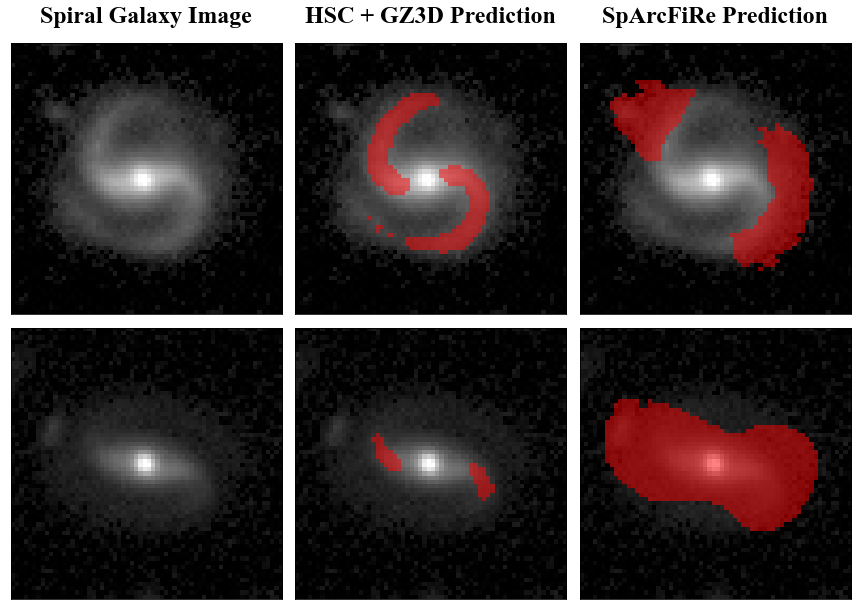

In [133]:
import os
import tensorflow as tf
from PIL import Image, ImageOps
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

galaxy_ids = [
    r"42261258421956171",
    r"42683621210879589",
    r"42683745764926902",
    r"42683754354857788",
    r"42683754354858507",
    r"42683900383748784",
    r"42684024937802161",
    r"42684029232771151",
    r"42684145196883501",
    r"42684158081786663",
]

folder = "..\data\Tadaki_Segmentation\set_2\images"
sparcfire_folder = "..\data\sparcfire"

MODEL_PATH = os.path.join(os.pardir, "models", "tuned_model_set_3.keras")

def compare(galaxy_ids, folder, sparcfire_folder):

    image_filepaths = [os.path.join(folder, f"{f}.jpg") for f in galaxy_ids]
    sf_paths = [os.path.join(sparcfire_folder, f,  f"{f}-D_clusMask.png") for f in galaxy_ids]

    model = tf.keras.models.load_model(MODEL_PATH)

    imgs = [np.expand_dims(np.array(Image.open(fp)), axis=0) for fp in image_filepaths]

    preds_model = [model.predict(tf.convert_to_tensor(img, dtype=tf.float64)) for img in imgs]
    preds_sf = [np.expand_dims(np.array(Image.open(fp).convert('L')), axis=0) for fp in sf_paths]

    overlay_cmap = mpl.colors.ListedColormap(['none', 'red'])
    
    # Filter examples where preds_sf is all black
    filtered_preds = [(predsf, predmodel, img) for (predsf, predmodel, img) in zip(preds_sf, preds_model, imgs) if predsf.max() > 0]
    
    preds_model = [predmodel for (predsf, predmodel, img) in filtered_preds]
    preds_sf = [predsf for (predsf, predmodel, img) in filtered_preds]
    imgs = [img for (predsf, predmodel, img) in filtered_preds]
    
    keep_indices = [0, 4]
    
    preds_model = [preds_model[i] for i in keep_indices]
    preds_sf = [preds_sf[i] for i in keep_indices]
    imgs = [imgs[i] for i in keep_indices]

    plt.figure(figsize=(12,60))

    for n, img in enumerate(imgs):
        img = img.reshape((64,64))
        pred_2 = preds_model[n].reshape((64,64))
        pred_3 = preds_sf[n].reshape((64,64))
        
        plt.subplot(15,3,3*n+1)
        if (n == 0):
            plt.title("Spiral Galaxy Image", fontsize=24, fontname='Times New Roman', y=1.05, weight='bold')
        plt.imshow(img, cmap='gray')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        plt.subplot(15,3,3*n+2)
        if (n == 0):
            plt.title("HSC + GZ3D Prediction", fontsize=24, fontname='Times New Roman', y=1.05, weight='bold')
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_2>0.5, cmap=overlay_cmap, alpha=0.5)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        plt.subplot(15,3,3*n+3)
        if (n == 0):
            plt.title("SpArcFiRe Prediction", fontsize=24, fontname='Times New Roman', y=1.05, weight='bold')
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_3>0.5, cmap=overlay_cmap, alpha=0.5)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()
    
compare(galaxy_ids, folder, sparcfire_folder)

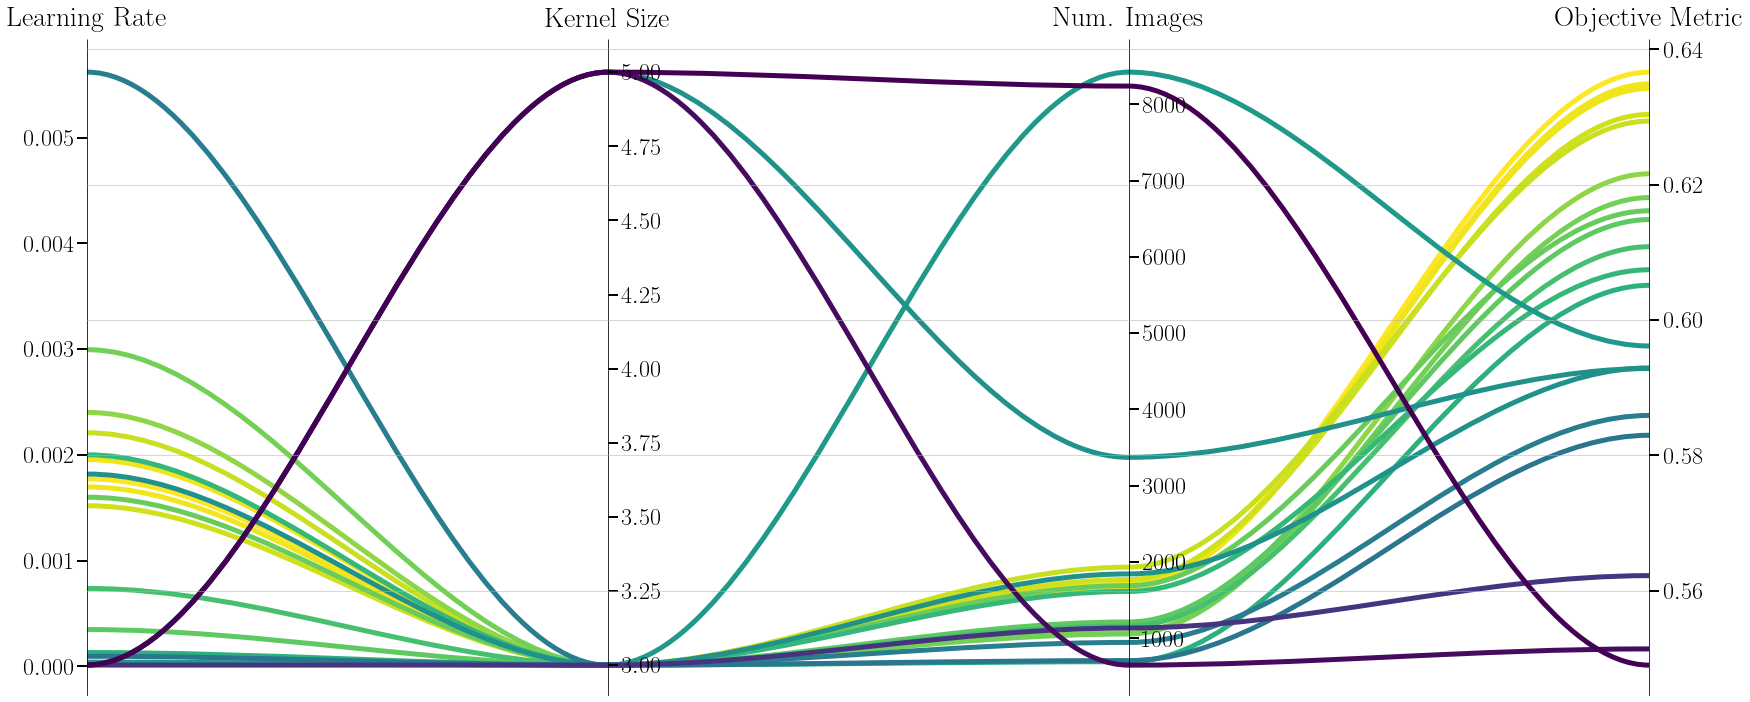

In [156]:
# Credit: Inspired by https://stackoverflow.com/a/60401570/10341389
""" Plot Parallel Coordinates plot of Hyperparameter Combinations """
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import json

mpl.rcParams['font.serif'] = "Times New Roman"
mpl.rcParams['font.family'] = "serif"

"""
Expects following JSON shape
    {
        "Objective": OBJECTIVE_TITLE
        "Results": [
            {
                "Trial": TRIAL_ID,
                "Hyperparameters": {
                    "learning_rate": float,
                    "kernel_size": int,
                    "num_images": int,
                    "Score": float
                }
            }
        ]
    }
"""
HP_RESULTS_FILE = r"..\models\hp_tuning_results.json"

with open(HP_RESULTS_FILE, "r") as read_file:
    data = json.load(read_file)

fig, host = plt.subplots(figsize=(28,12))

# create some dummy data
ynames = ['Learning Rate', 'Kernel Size', 'Num. Images', "Objective Metric"]
y1 = [d['Hyperparameters']['learning_rate'] for d in data['Results']]
y2 = [d['Hyperparameters']['kernel_size'] for d in data['Results']]
y3 = [d['Hyperparameters']['num_images'] for d in data['Results']]
y4 = [-d['Hyperparameters']['Score'] for d in data['Results']]

# organize the data
ys = np.dstack([y1, y2, y3, y4])[0]
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='y', labelsize=24, length=10, width=2)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=28)
host.tick_params(axis='x', which='major', pad=7)

host.spines['right'].set_visible(False)
host.xaxis.tick_top()
#host.set_title('Hyperparameter Tuning: Parallel Coordinates Plot', fontsize=18,y=1.1)

cmap = plt.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=min(y4), vmax=max(y4))

for j in range(len(ys)):
    
    # to just draw straight lines between the axes:
    # host.plot(range(ys.shape[1]), zs[j,:], c=colors[(category[j] - 1) % len(colors) ])

    # create bezier curves
    # for each axis, there will a control vertex at the point itself, one at 1/3rd towards the previous and one
    #   at one third towards the next axis; the first and last axis have one less control vertex
    # x-coordinate of the control vertices: at each integer (for the axes) and two inbetween
    # y-coordinate: repeat every point three times, except the first and last only twice
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    
    # for x,y in verts: host.plot(x, y, 'go') # to show the control points of the beziers
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=5, edgecolor=cmap(norm(y4[j])))
    host.add_patch(patch)

# Make background of plot gray
#host.set_facecolor('#E6E6E6')

plt.grid(True, axis='y', linewidth=1, alpha=0.5)
plt.show()